# The Most Comfortable Place in America
---
<br>

<h3>Where are the most comfortable places in America at this very moment?</h3> 
<p>I have no idea, but we're going to find out! Here's how:</p>
<ol>
    <li>Get and clean the data</li>
    <li>Set up some utilities</li>
    <li>Visualize the conditions</li>
    <li>Come to a conclusion</li>
    <li>Summarize the results</li>
</ol>

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from citipy import citipy
import gmaps
import datetime as dt
import gmaps.geojson_geometries as gdata
import palettable as pt

# Import API key
from supersecret import owm_key,gmaps_key
gmaps.configure(api_key= gmaps_key)
owm_url = 'http://api.openweathermap.org/data/2.5/weather'

## Generate Cities List
---
First we set the boundary box for the US using latitude and longitude values, I used [bboxfinder](http://bboxfinder.com/) to make it easier. We will filter through the resulting cities by country code so it doesn't have to be super accurate, just eyeball it.

<br>

**Some Considerations**:

* 1500 may seem high but we're going to trim that down by the time we're done.
* We still want full coverage without duplicates so that number has to be relatively high.
* We want to clean the data before we make the api calls to limit the number of required requests. In this case, we'll make sure there are no duplicates and use only cities in the US


In [2]:
# US BBox
lat = [24.206890,48.922499]
lng = [-126.386719,-59.765625]

citySet = set()

while len(citySet) < 1500:
    cty_lat = round(np.random.uniform(lat[0],lat[1]),3)
    cty_lng = round(np.random.uniform(lng[0],lng[1]),3)
    city = citipy.nearest_city(cty_lat, cty_lng)
    citySet.add((city.city_name.capitalize(),
                 city.country_code.upper(),
                 cty_lat, cty_lng))
    
# Convert list of tuples into a dataframe
cities_df = pd.DataFrame(citySet, columns = ['City', 'Country Code', 'Latitude', 'Longitude'])
cities_df["Temperature"] = np.NaN
cities_df["Humidity"] = np.NaN
cities_df["Cloudiness"] = np.NaN
cities_df["Wind Speed"] = np.NaN

# Filter on Country Code then drop duplicates and confirm
cities_df = cities_df.loc[cities_df['Country Code'] == 'US']
cities_df = cities_df.drop_duplicates(subset='City').set_index('City')
cities_df.head()

,Country Code,Latitude,Longitude,Temperature,Humidity,Cloudiness,Wind Speed
City,,,,,,,
Freeport,US,27.389,-94.901,NaN,NaN,NaN,NaN
Pueblo,US,38.187,-103.853,NaN,NaN,NaN,NaN
Sun valley,US,39.914,-120.009,NaN,NaN,NaN,NaN
Virginia beach,US,35.702,-71.629,NaN,NaN,NaN,NaN
Douglas,US,31.584,-82.824,NaN,NaN,NaN,NaN


## Perform API Calls
---
Credit for most of this goes to Martha as I ~~backhandedly stole~~ refactored her code for this example.  The only things I added were the `print('',end='\r')` to return the carriage at the end of the line and some changes to the Start and Done code.

In [3]:
# Get weather info for each city
params = {
    "appid": owm_key,
    "units": 'imperial'
}

# read countries in the dataframe and get weather information for each one
print(f"{'-'*35} Start {'-'*35}")
for idx, value in cities_df.iterrows():
    try:
        
        # add the cityname (and country code) to params dict
        params['q'] = f"{idx},{value['Country Code']}"
        # Call de API and jsonify
        we_info_city = requests.get(owm_url, params=params).json()

        # Add the required information to the dataframe
        cities_df.loc[idx, "Temperature"] = we_info_city["main"]["temp"]
        cities_df.loc[idx, "Humidity"] = we_info_city["main"]["humidity"]
        cities_df.loc[idx, "Cloudiness"] = we_info_city["clouds"]["all"]
        cities_df.loc[idx, "Wind Speed"] = we_info_city["wind"]["speed"]
        ctry_id = we_info_city["id"]
        
        # print city      
        print(f"Processing {idx}{'.'*25}", end="\r")

    # catch possible errors if the coordinates do NOT exist, or any of the datapoints in NOT available    
    except (KeyError, IndexError):
        print(f"{idx} not found", end='\r')

# Get rid of any lines with NaN values in any column
print(f"{'-'*36} Done {'-'*35}")
cities_df = cities_df.dropna(axis=0, how="any")
              
# Save the dataframe to a file
cities_df.to_csv("output/cities.csv", index=False, header=True)

----------------------------------- Start -----------------------------------
------------------------------------ Done -----------------------------------


In [4]:
# Check the number of surviving cities
len(cities_df)

517

## Find United States in geojson_geometries
---
**Heatmaps are weird**: In order to show change accurately, you need both contrast from the map and gradual change over different values. If you can't change the base color to `(0,0,0,0)` *or stylistically choose not to*,  it's a good idea to highlight the area you're looking at to distinguish it from other the areas you're not of interest.
<br>
<br>
We're going to do that with a **geojson overlay**.  Gmaps has a data set containing geojson geometries for 217 countries, so we'll use that.  But we only want one country so we're going to extract it, transform it back into the appropriate format, and load it into the gmap layer. There is a little domain knowledge required here in the form of knowing the standardized geojson format well enough to know how to find what you're looking for but it's only a Google search away from being yours. *(That's right Brian, I'm going to make you use Google)*

In [5]:
# Load geojson data from gmaps.data
us_feature = gdata.load_geometry('countries')['features']
# Loop through countries to match the US on ISO_A3 Country Code and isolate it
for i in range(0,len(us_feature)):
    if us_feature[i]['properties']['ISO_A3'] == 'USA':
        us_val=i
        us_geojson={
        "type":"FeatureCollection",
        "features": [us_feature[us_val]]
        }
        break

# Confirm Accuracy
print(us_geojson['features'][0]['properties']['name'])

United States of America


## Plot Gen Functions
---
We're going to run this code several times throughout this notebook but we will only change one or two values each time. So let's make a function. 
<br>
<br>
We'll use different colormaps for each of the metrics we're tracking, I used a few I sourced from the [palettable](https://jiffyclub.github.io/palettable/) library. Since we'll be reusing these color maps for the gmaps, you'll want them to represent what you're displaying so it's **immediately clear** *what you're looking at and what it means*.

In [6]:
# Define colormaps 
temp = pt.cartocolors.diverging.Temps_7
humidity = pt.cmocean.diverging.Balance_20_r # _r denotes reversed
clouds= pt.mycarta.CubeYF_20_r
wind = pt.cartocolors.sequential.Sunset_7

def plot_gen(c,cmap,ax=None,show=True,save=True,df=cities_df):
    date = dt.date.today().strftime('%m/%d/%Y')
    plot = df.plot.scatter(x = 'Longitude',
                                 y = 'Latitude',
                                 c = c,
                                 s = 75,
                                 grid = True,
                                 figsize = (16,9),
                                 title = f"US {c} for {date}",
                                 cmap = cmap.mpl_colormap,
                                 ax=ax)
    plt.xlabel('Longitude')
    plt.tight_layout()
    # Save the chart
    if save==True:
        plt.savefig(f"img/US_Weather.png")
    else:
        pass
    # Now we can show the image, otherwise we get a blank png
    if show==True:
        plt.show()
    else:
        pass
    
# This is mostly to save space in the outputs and not strictly neccessary
def multi_plot_gen():
    fig = plt.figure()
    # 2x2 Grid of plots
    ax1 = fig.add_subplot(221)
    plot_gen('Temperature',temp,ax=ax1,show=False,save=False)
    
    ax2=fig.add_subplot(222)
    plot_gen('Humidity',humidity,ax=ax2,show=False,save=False)
    
    ax3=fig.add_subplot(223)
    plot_gen('Cloudiness',clouds,ax=ax3,show=False,save=False)
    
    ax4=fig.add_subplot(224)
    plot_gen('Wind Speed',wind,ax=ax4,show=False,save=True)
    
    # Set total fig dimensions
    fig.set_figheight(12)
    fig.set_figwidth(21)

## Map Gen function
---
Now for the fun part.
<br>
<br>



In [7]:
# Set Map Gradient options and convert list of lists to list of tuples
# convert list of lists into list of tuples
def tuplize(cmap):
    colors = [tuple(color) for color in cmap.colors]
    return colors
    
map_temp = tuplize(temp)
map_hum = tuplize(humidity)
map_cloud= tuplize(clouds)
map_wind = tuplize(wind)

def map_gen(column,max_intensity=90, point_radius=20,gradient=map_temp,size=700,df=cities_df):
    # Set locations
    locations = df.reset_index()[['Latitude','Longitude']]
    # Weights are equal to column input. i.e. 'Temperature'
    weights = df[[column]].reset_index()[column].apply(lambda x:x**2)
    #Layout
    figure_layout = {
        'width':f'{size}px'
    }
    fig = gmaps.figure(center=(38.925229,-97.954102),
                       zoom_level=4,
                       map_type='HYBRID',
                       layout=figure_layout)
    # Set heatmap_layer values to function parameters and default values
    heatmap_layer = gmaps.heatmap_layer(locations,
                                        weights = weights,
                                        point_radius = point_radius,
                                        max_intensity = max_intensity,
                                        gradient=gradient,
                                        opacity=0.8)
    fig.add_layer(heatmap_layer)
    
    #geojson geometries
    us_layer = gmaps.geojson_layer(us_geojson,fill_color=(150,150,150,0.4))
    fig.add_layer(us_layer)
    
    return fig

def final_map(size=700):
    locations = optimal.reset_index()[['Latitude','Longitude']]
    markers = gmaps.symbol_layer(locations,fill_color = 'blue',stroke_color = 'black', scale=3)
    figure_layout = {
        'width':f'{size}px'
    }
    fig = gmaps.figure(center=(38.925229,-97.954102),
                       zoom_level=4,
                       layout=figure_layout)
    fig.add_layer(markers)
    
    #geojson geometries
    us_layer = gmaps.geojson_layer(us_geojson,fill_color=(150,150,150,0.1))
    fig.add_layer(us_layer)
    
    return fig

## Visualize the whole country
---
Let's see what we have to work with.  These four plots will help us see what's going on in the whole country. *This step is not neccessary to get the answer to our question but it's a good step to do while your on your way to the conclusion...and it's fun*

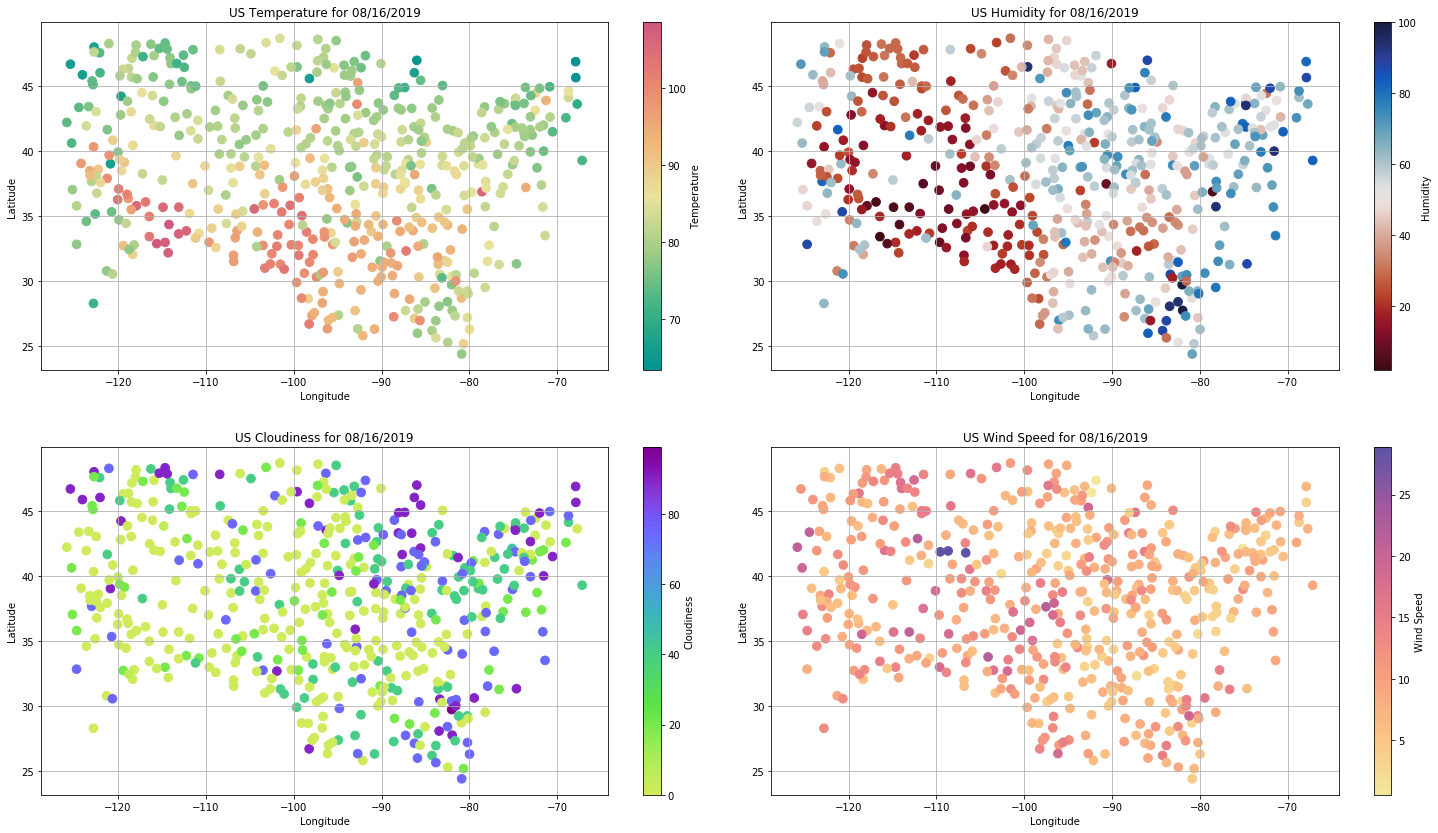

In [8]:
multi_plot_gen()

In [9]:
# Temperature Heatmap
map_gen('Temperature',max_intensity=100000,point_radius=50)

Figure(layout=FigureLayout(height='420px', width='700px'))

In [10]:
# Humidity Heatmap
map_gen('Humidity',max_intensity=35000,point_radius=40,gradient=map_hum)

Figure(layout=FigureLayout(height='420px', width='700px'))

In [11]:
# Cloudiness Heatmap
map_gen("Cloudiness",max_intensity=50000,point_radius=60,gradient=map_cloud)

Figure(layout=FigureLayout(height='420px', width='700px'))

In [12]:
# Wind Speed Heatmap
map_gen('Wind Speed',max_intensity=1500,point_radius=50,gradient=map_wind)

Figure(layout=FigureLayout(height='420px', width='700px'))

In [13]:
# Boolean indexing for chained filter on optimal conditions
temp_bottom, temp_top = (cities_df['Temperature'] >= 68),(cities_df['Temperature'] <=77 )
hum_bottom, hum_top = (cities_df['Humidity'] >= 40) , (cities_df['Humidity'] <= 50)
cloud_bottom, cloud_top = (cities_df['Cloudiness'] >= 0 ) , (cities_df['Cloudiness'] <= 20)
wind_bottom, wind_top = (cities_df['Wind Speed'] >= 1) , (cities_df['Wind Speed'] <= 13)

## Temperature: 68F-77F
---
Ideal temperature is easy. The range 20C-25C (*68-77 Freedom degrees for Americans*) is considered by most to be a comfortable range to be indoors so why not aim for the same outdoors.

In [14]:
optimal = cities_df[temp_bottom & temp_top]
final_map()

Figure(layout=FigureLayout(height='420px', width='700px'))

## Humidity: 40%-50%
---
According to the [top result](https://www.thermastor.com/relative-humidity-and-your-home/) when googling "best humidity level", the desireable humidity range is between 40%-50% humidity. The info came from a humidifier company and they wouldn't lie just to sell a product would they?

In [15]:
optimal = optimal[hum_bottom & hum_top]
final_map()

C:\Users\justi\Anaconda3\envs\Storytime\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Figure(layout=FigureLayout(height='420px', width='700px'))

## Cloudiness: 0%-20%
---
Clouds cause depression. I found it on WebMD so it must be true. They even go so far as to mention a study showing an increase in negative Facebook posts as weather gets worse.  I couldn't find a citation but I'm sure it came from a reputable peer-reviewed journal. I also told them I sneezed yesterday and had a headache once and they diagnosed me with subacute bacterial endocarditis. Anyway, let's aim for between 0% and 20%.
<br>
<br>


**Update**: I found the study they mentioned -- A surprisingly well done study from the Germans at the illustrious [Fanpage Karma blog](https://blog.fanpagekarma.com/2013/12/04/rains-users-react-facebook-posts/) known for hard hitting stories like *"Top 10 most relevant Topics on Instagram"* and *"How you can influence your fans with emotional posts: The Infographic"*.

In [16]:
optimal = optimal[cloud_bottom & cloud_top]
final_map()

C:\Users\justi\Anaconda3\envs\Storytime\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Figure(layout=FigureLayout(height='420px', width='700px'))

## Wind Speed: 1mph - 13mph
---
The [Beaufort Wind Scale](https://en.wikipedia.org/wiki/Beaufort_scale) paints a vivid picture of ideal windo conditions for our utopian destination. We're aiming for somewhere between a 1 and a 3 on the scale which translates to 0.5-5.5m/s (*1-13 Freedom miles per Freedom hour*). This is the "Light Air" to "Gentle Breeze" range and it sounds delightful.

In [17]:
optimal = optimal[wind_bottom & wind_top]
final_map()

C:\Users\justi\Anaconda3\envs\Storytime\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Figure(layout=FigureLayout(height='420px', width='700px'))

In [18]:
optimal.head(20)

,Country Code,Latitude,Longitude,Temperature,Humidity,Cloudiness,Wind Speed
City,,,,,,,
Pacific grove,US,34.599,-123.614,74.98,49.0,1.0,12.75
Newberg,US,45.388,-122.955,73.69,40.0,20.0,9.17
Woodburn,US,45.105,-122.857,73.80,40.0,20.0,9.17
Dillon,US,45.336,-112.733,75.13,43.0,20.0,5.82
Roseburg,US,43.418,-123.339,76.14,50.0,1.0,9.17
Monterey,US,35.163,-122.613,73.74,49.0,1.0,12.75
Hot springs,US,34.486,-93.922,76.32,43.0,1.0,12.75
